In [21]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

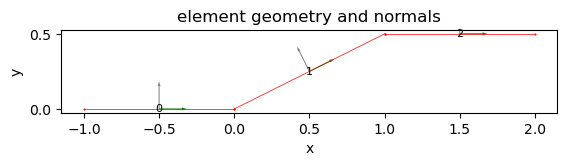

In [22]:
mu = 1.0
els = bemcs.initialize_els()

# setup a fault geometry
els.x1 = np.array([-1.0, 0.0, 1.0])
els.y1 = np.array([0.0, 0.0, 0.5])
els.x2 = np.array([0.0, 1.0, 2.0])
els.y2 = np.array([0.0, 0.5, 0.5])

slip_vector = np.array([-0.5, 1, 0.5])

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [23]:
# # Observation points
# xo = np.linspace(-2, 2, 100).reshape(-1, 1)
# yo = np.zeros_like(xo) + 1e-6

nx_obs = 250
ny_obs = 200
x_obs = np.linspace(-2, 3, nx_obs)
y_obs = np.linspace(-2, 2, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

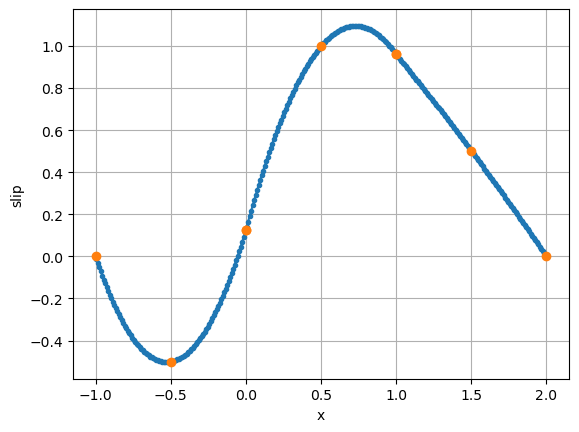

In [24]:
stride = 3
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient_antiplane(
    els, flag="node"
)
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride, 1))
bc_vec[0] = 0.0
bc_vec[-1] = 0.0
bc_vec[1::stride] = slip_vector.reshape(-1, 1)

# Populate design matrix
# Boundary nodes
design_mat[0, :] = slip_mat[0, :]
design_mat[-1:, :] = slip_mat[-1:, :]

# Patch center nodes
design_mat[1::stride, :] = slip_mat[1::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity
design_mat[2:-2:stride, :] = slip_mat[2:-2:stride, :] - slip_mat[3:-2:stride, :]

# Smoothness
design_mat[3:-2:stride, :] = (
    slip_gradient_mat[2:-2:stride, :] - slip_gradient_mat[3:-2:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
quadcoefs = np.linalg.inv(design_mat) @ bc_vec
# quadcoefs = np.array([1, 1, 1, 0, 1, 0]).reshape(-1, 1)

# compute slip at nodes
xf = np.zeros(3 * n_els)
xf[0::3] = els.x1
xf[1::3] = els.x_centers
xf[2::3] = els.x2
xnodes, _, slipnodes = bemcs.get_slipvector_on_fault_antiplane(
    els, quadcoefs.flatten(), 100
)
plt.figure()
plt.plot(xnodes, slipnodes, ".-")
plt.plot(xf, slip_mat @ quadcoefs, "o")
plt.xlabel("x")
plt.ylabel("slip")
plt.grid()
plt.show()
# print(np.vstack((xf, slip_mat @ quadcoefs.flatten())).T)

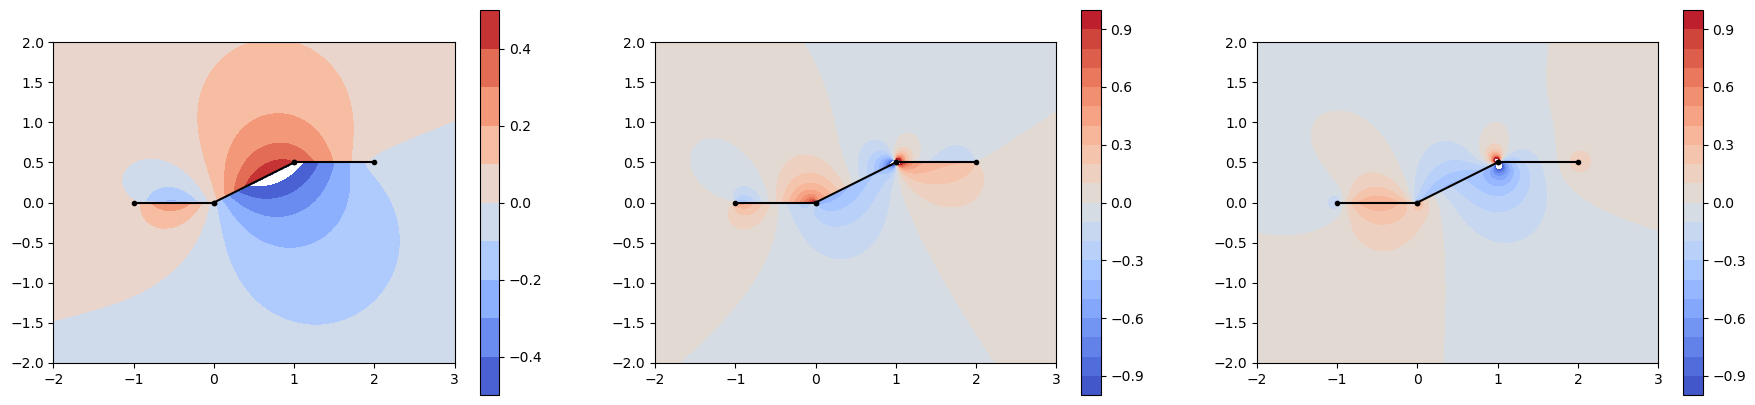

In [25]:
u = K_u @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 2)
toplot = sx.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
toplot = sy.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

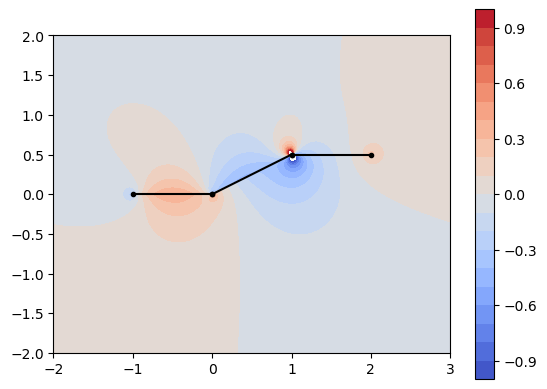

In [26]:
# compute traction kernels
els_plot = bemcs.initialize_els()
els_plot.x_normals = 0 * np.ones_like(xo).T
els_plot.y_normals = 1 * np.ones_like(xo).T

K_t = bemcs.get_traction_kernels_antiplane(els_plot, tuple([K_sx, K_sy]))
t = K_t @ quadcoefs

plt.figure()
toplot = t.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()